## **Load Root Google Drive File dan Import Library**

In [1]:
## Load Folder Drive
import os, sys
from google.colab import drive
drive.mount('/content/drive/')

## Move Pointer File ke DATA_UM
%cd /content/drive/MyDrive/DATA_UM

## Declare Root Project File
root_file = "/content/drive/MyDrive/DATA_UM"

Mounted at /content/drive/
/content/drive/MyDrive/DATA_UM


In [2]:
## Install necessary libraries
# &> /dev/null = Remove output Install
!pip install transformers &> /dev/null

# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import re
import string

import os.path
from os import path

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Load Data and Transforming as Required**

####**Load Data for Training, Testing, and Validating**

In [3]:
## Declare Hashtag Data
hashtag = "ultramilk_revisi_5april"
folder = "ultramilk_revisi_5april"

if path.exists(root_file+'/report/'+hashtag) == False:
  os.makedirs(root_file+'/report/'+hashtag)

In [4]:
## Load Data Training
df = pd.read_csv('data/training/'+folder+'/'+folder+'_all.csv')
df.shape

(14037, 17)

In [5]:
df['id_tweet'] = df.index

####**Labelling Rules (Polarity) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive to Product,
##### 3 = Positive to Others, and
##### 4 = Not Related (other topic / other language).

In [6]:
## Declare DF For Graph Penyebaran Class
df_class_polarity = pd.DataFrame(
    {
        'class': ['Negative\n(0)', 'Neutral\n(1)', 'Positive to Product\n(2)', 'Positive to Others\n(3)', 'Not Related\n(4)'],
        'id_class' : [0, 1, 2, 3, 4],
        'total': [df[df.labelling == 0].shape[0], df[df.labelling == 1].shape[0], df[df.labelling == 2].shape[0], df[df.labelling == 3].shape[0], df[df.labelling == 4].shape[0]]
        }
    )

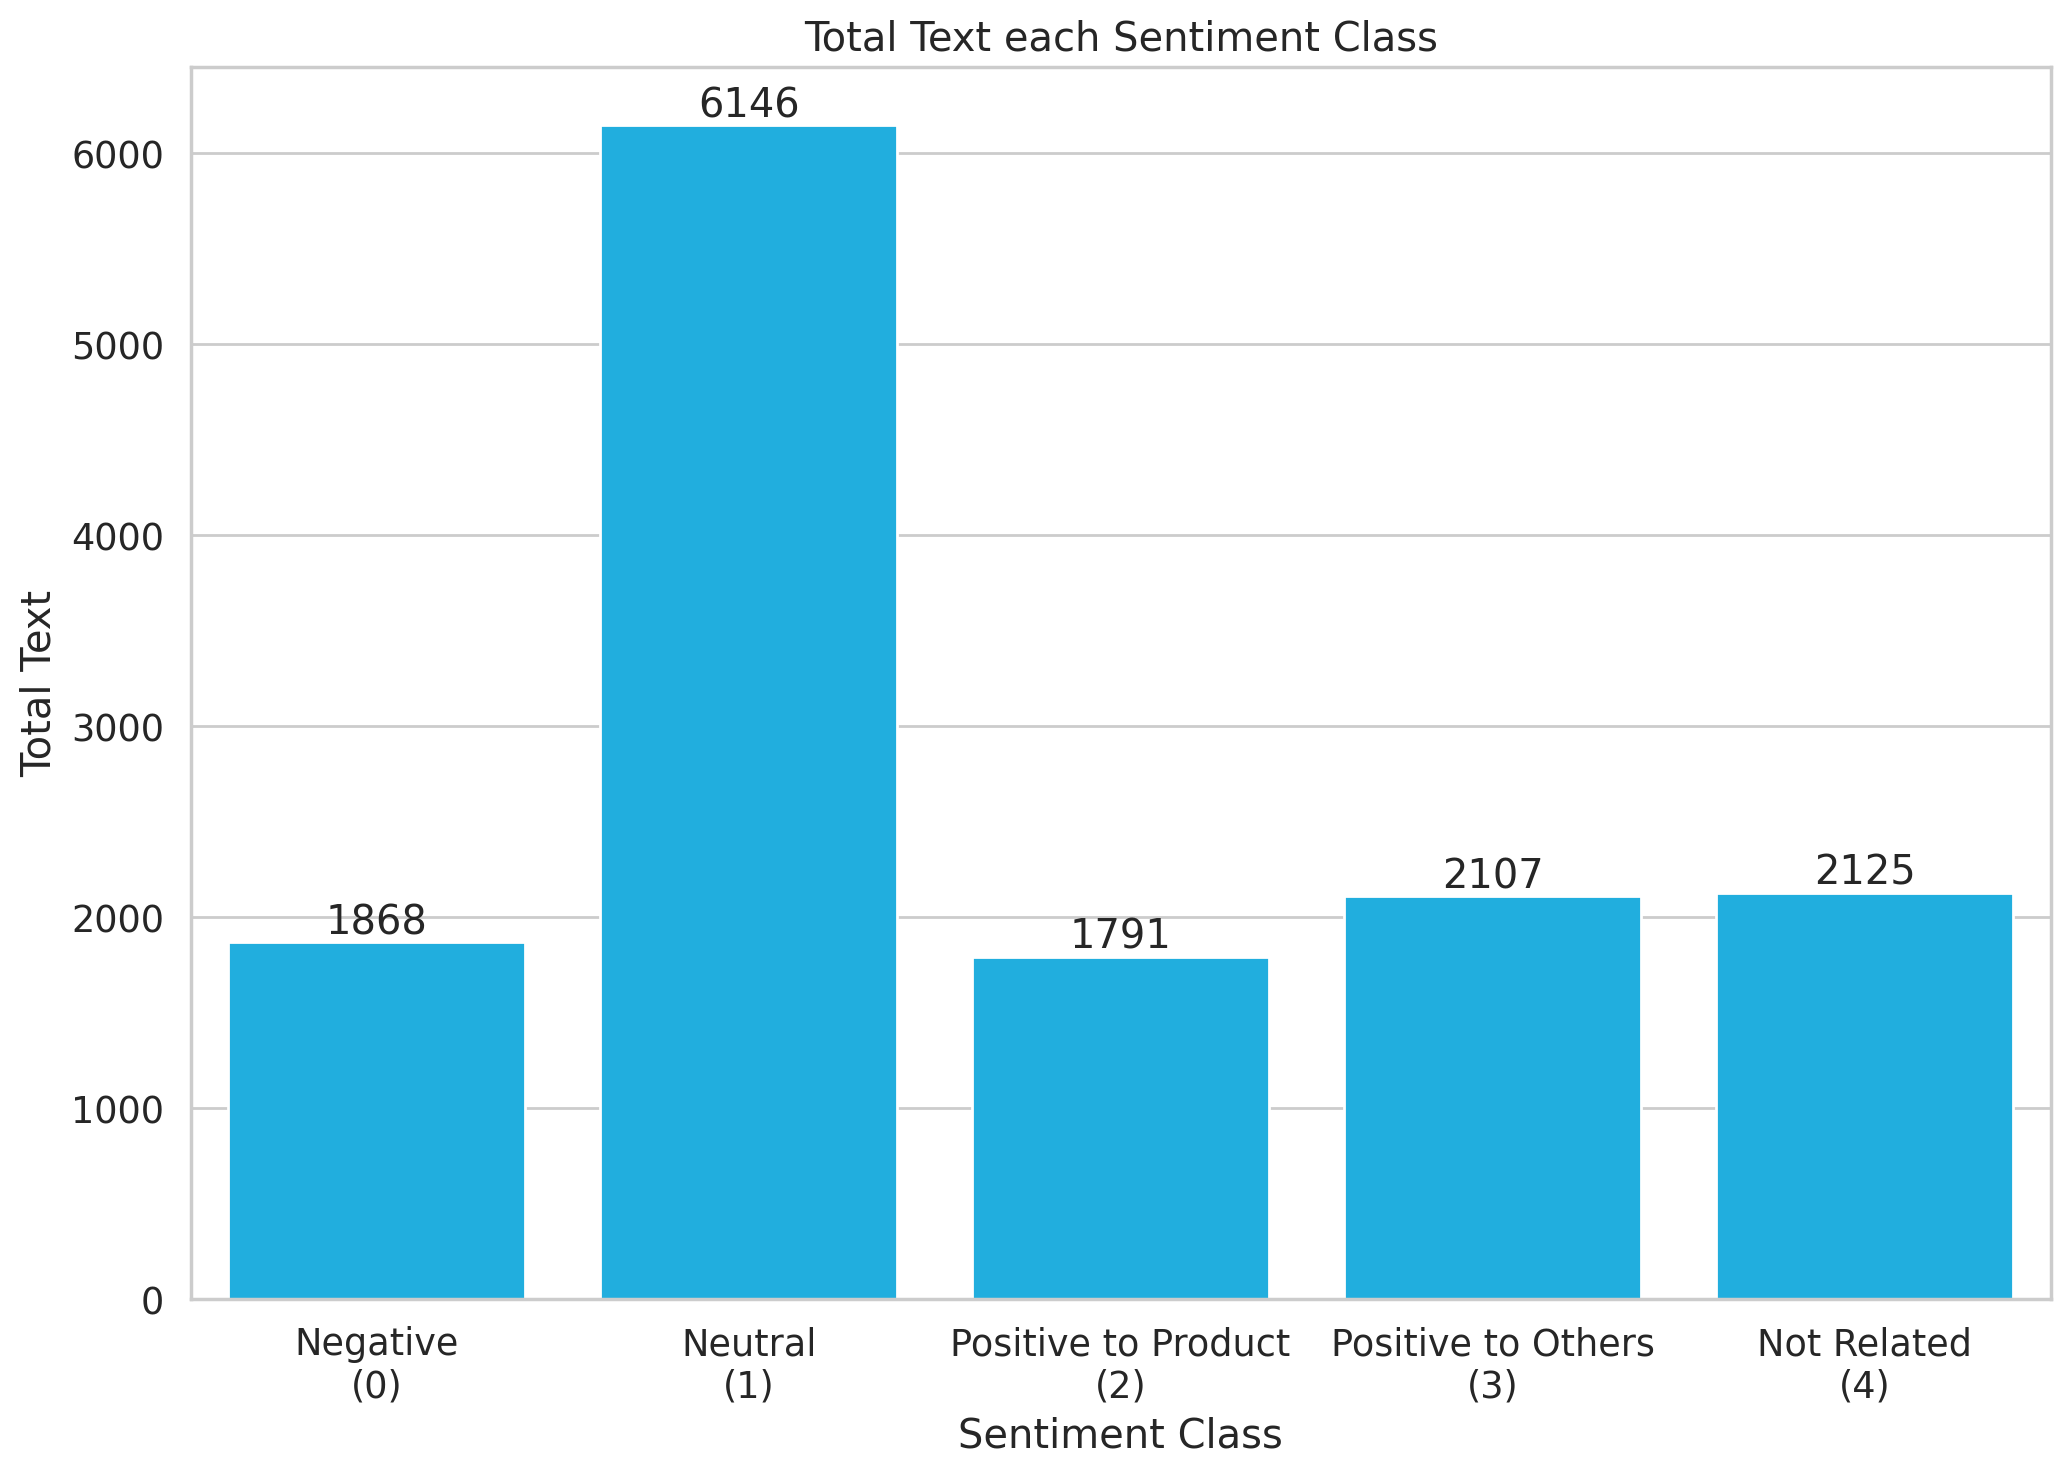

In [7]:
## Draw Graph Penyebaran Class Polaritas / Labelling
ax = sns.barplot(data=df_class_polarity, x='class', y='total');
ax.set(xlabel='Sentiment Class',
       ylabel='Total Text',
       title='Total Text each Sentiment Class')
ax.bar_label(container=ax.containers[0], labels=df_class_polarity.total)

# Save Image
plt.savefig('report/'+hashtag+'/total_penyebaran_kelas_labelling.png')

####**Labelling Rules (Data Training) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive - (Product, BA and others)

In [8]:
## LDuplicate Dataframe
df_data = df
df_data_asli = df

## Remove unused Column in DF for Training
df_data = df_data.drop(columns=['date', 'platform',	'brand', 'hashtag', 'name', 'username', 'profile_id', 'comments', 'share_retweet', 'bookmark', 'quotes', 'likes'])

## Adding Collumn Sentiment for Training Model
df_data['labelled'] = 0
df_data_asli['labelled'] = 0

In [9]:
# Function to convert score to sentiment
def to_sentiment(rating):
    rating = int(rating)
    # Convert to class
    if rating == 0:
      return 0
    elif rating == 1:
      return 1
    elif rating == 2 or rating == 3:
      return 2

# Apply to the dataset
df_data['labelled'] = df_data.labelling.apply(to_sentiment)
df_data_asli['labelled'] = df_data_asli.labelling.apply(to_sentiment)

In [10]:
# Delete Rows that has value 4 in Polarity (4 tidak dipakai)
df_data = df_data[df.labelling != 4]
df_data['labelled']

0        1.0
1        1.0
2        1.0
3        2.0
4        1.0
        ... 
14030    2.0
14031    1.0
14032    2.0
14033    0.0
14035    0.0
Name: labelled, Length: 11912, dtype: float64

In [11]:
df_data

,id_tweet,link,text,labelling,text_final,labelled
0,0,https://www.tiktok.com/@uglyeoja/video/7143900...,Yuviii,1,yuvi,1.0
1,1,https://www.instagram.com/p/CftPm-yho6M,@__inayatulll__ yuniiiii😍😂,1,yuni,1.0
2,2,https://www.instagram.com/p/Cfu2lbTh2y8,Yuna 😍,1,yuna,1.0
3,3,Mentionlytics,"Halo teman - teman, saya mau sharing nih, peng...",2,halo teman teman mau sharing alam juang kumpul...,2.0
4,4,Mentionlytics,sebulan penuh bersama ultramilk jaya jaya jaya...,1,bulan penuh sama ultramilk jaya jaya jaya tert...,1.0
...,...,...,...,...,...,...
14030,14030,https://www.instagram.com/p/Cf-n-2NP-Tc,Ayaang,3,ayaang,2.0
14031,14031,https://www.instagram.com/p/CjKZD_rN2t2,otwww,1,otw,1.0
14032,14032,https://www.instagram.com/p/CzFsyLArKoe,kesyukaanku,2,kesyukaanku,2.0
14033,14033,https://www.instagram.com/p/CbBnsdpJ1MV,@m_husen90 Sekelas ultramilk ngadain ultramilk...,0,kelas ultramilk ada harus isi data2 ktp npwp c...,0.0


In [12]:
df_data_neg = df_data[df_data.labelled == 0]
df_data_net = df_data[df_data.labelled == 1]
df_data_pos = df_data[df_data.labelled == 2]

print(df_data_neg.shape, df_data_net.shape, df_data_pos.shape)

df_neg = df_data_neg
#df_net = df_data_net
df_net = df_data_net.sample(n=3898)
df_pos = df_data_pos

print(df_neg.shape, df_net.shape, df_pos.shape)

(1868, 6) (6146, 6) (3898, 6)
(1868, 6) (3898, 6) (3898, 6)


In [13]:
df_data = pd.concat([df_neg, df_net, df_pos], ignore_index=True)
df_data

,id_tweet,link,text,labelling,text_final,labelled
0,62,https://www.tiktok.com/@tehbotolsosroid/video/...,Hah kalo demam🥰,0,demam,0.0
1,69,https://www.instagram.com/p/Cy41pw2LVF8,Nangisss😢❤️❤️,0,tangis,0.0
2,95,https://www.instagram.com/p/Cz6FF2pBooT,@bestiee.shopee bisa aja kan gimmick 😂😂,0,gimmick,0.0
3,105,https://www.instagram.com/p/CjKZD_rN2t2,"susah bgt dpt chaeryeong, aku udah beli 50an m...",0,susah banget dapat chaeryeong sudah beli 50an ...,0.0
4,128,https://www.tiktok.com/@makanlurr/video/730127...,masih sepi😁,0,sepi,0.0
...,...,...,...,...,...,...
9659,14007,Mentionlytics,susu UHT ultramilk rasa full cream kecil jg ad...,2,susu uht ultramilk rasa full cream kecil ada w...,2.0
9660,14009,https://www.instagram.com/p/CjKZD_rN2t2,"Alhamdulillah dapat. Gengs kalo semisal nanya,...",3,alhamdulillah dapat gengs misal tanya langsung...,2.0
9661,14022,https://www.instagram.com/p/Cf-n-2NP-Tc,Omooo😍😍😍,3,omo,2.0
9662,14030,https://www.instagram.com/p/Cf-n-2NP-Tc,Ayaang,3,ayaang,2.0


In [14]:
## Declare DF For Graph Penyebaran Class
df_class_sentimen = pd.DataFrame(
    {
        'class': ['Negative\n(0)', 'Neutral\n(1)', 'Positive\n(2)'],
        'id_class' : [0, 1, 2],
        'total': [df_data[df_data.labelled == 0].shape[0], df_data[df_data.labelled == 1].shape[0], df_data[df_data.labelled == 2].shape[0]]
        }
    )
df_class_sentimen

,class,id_class,total
0,Negative\n(0),0,1868
1,Neutral\n(1),1,3898
2,Positive\n(2),2,3898


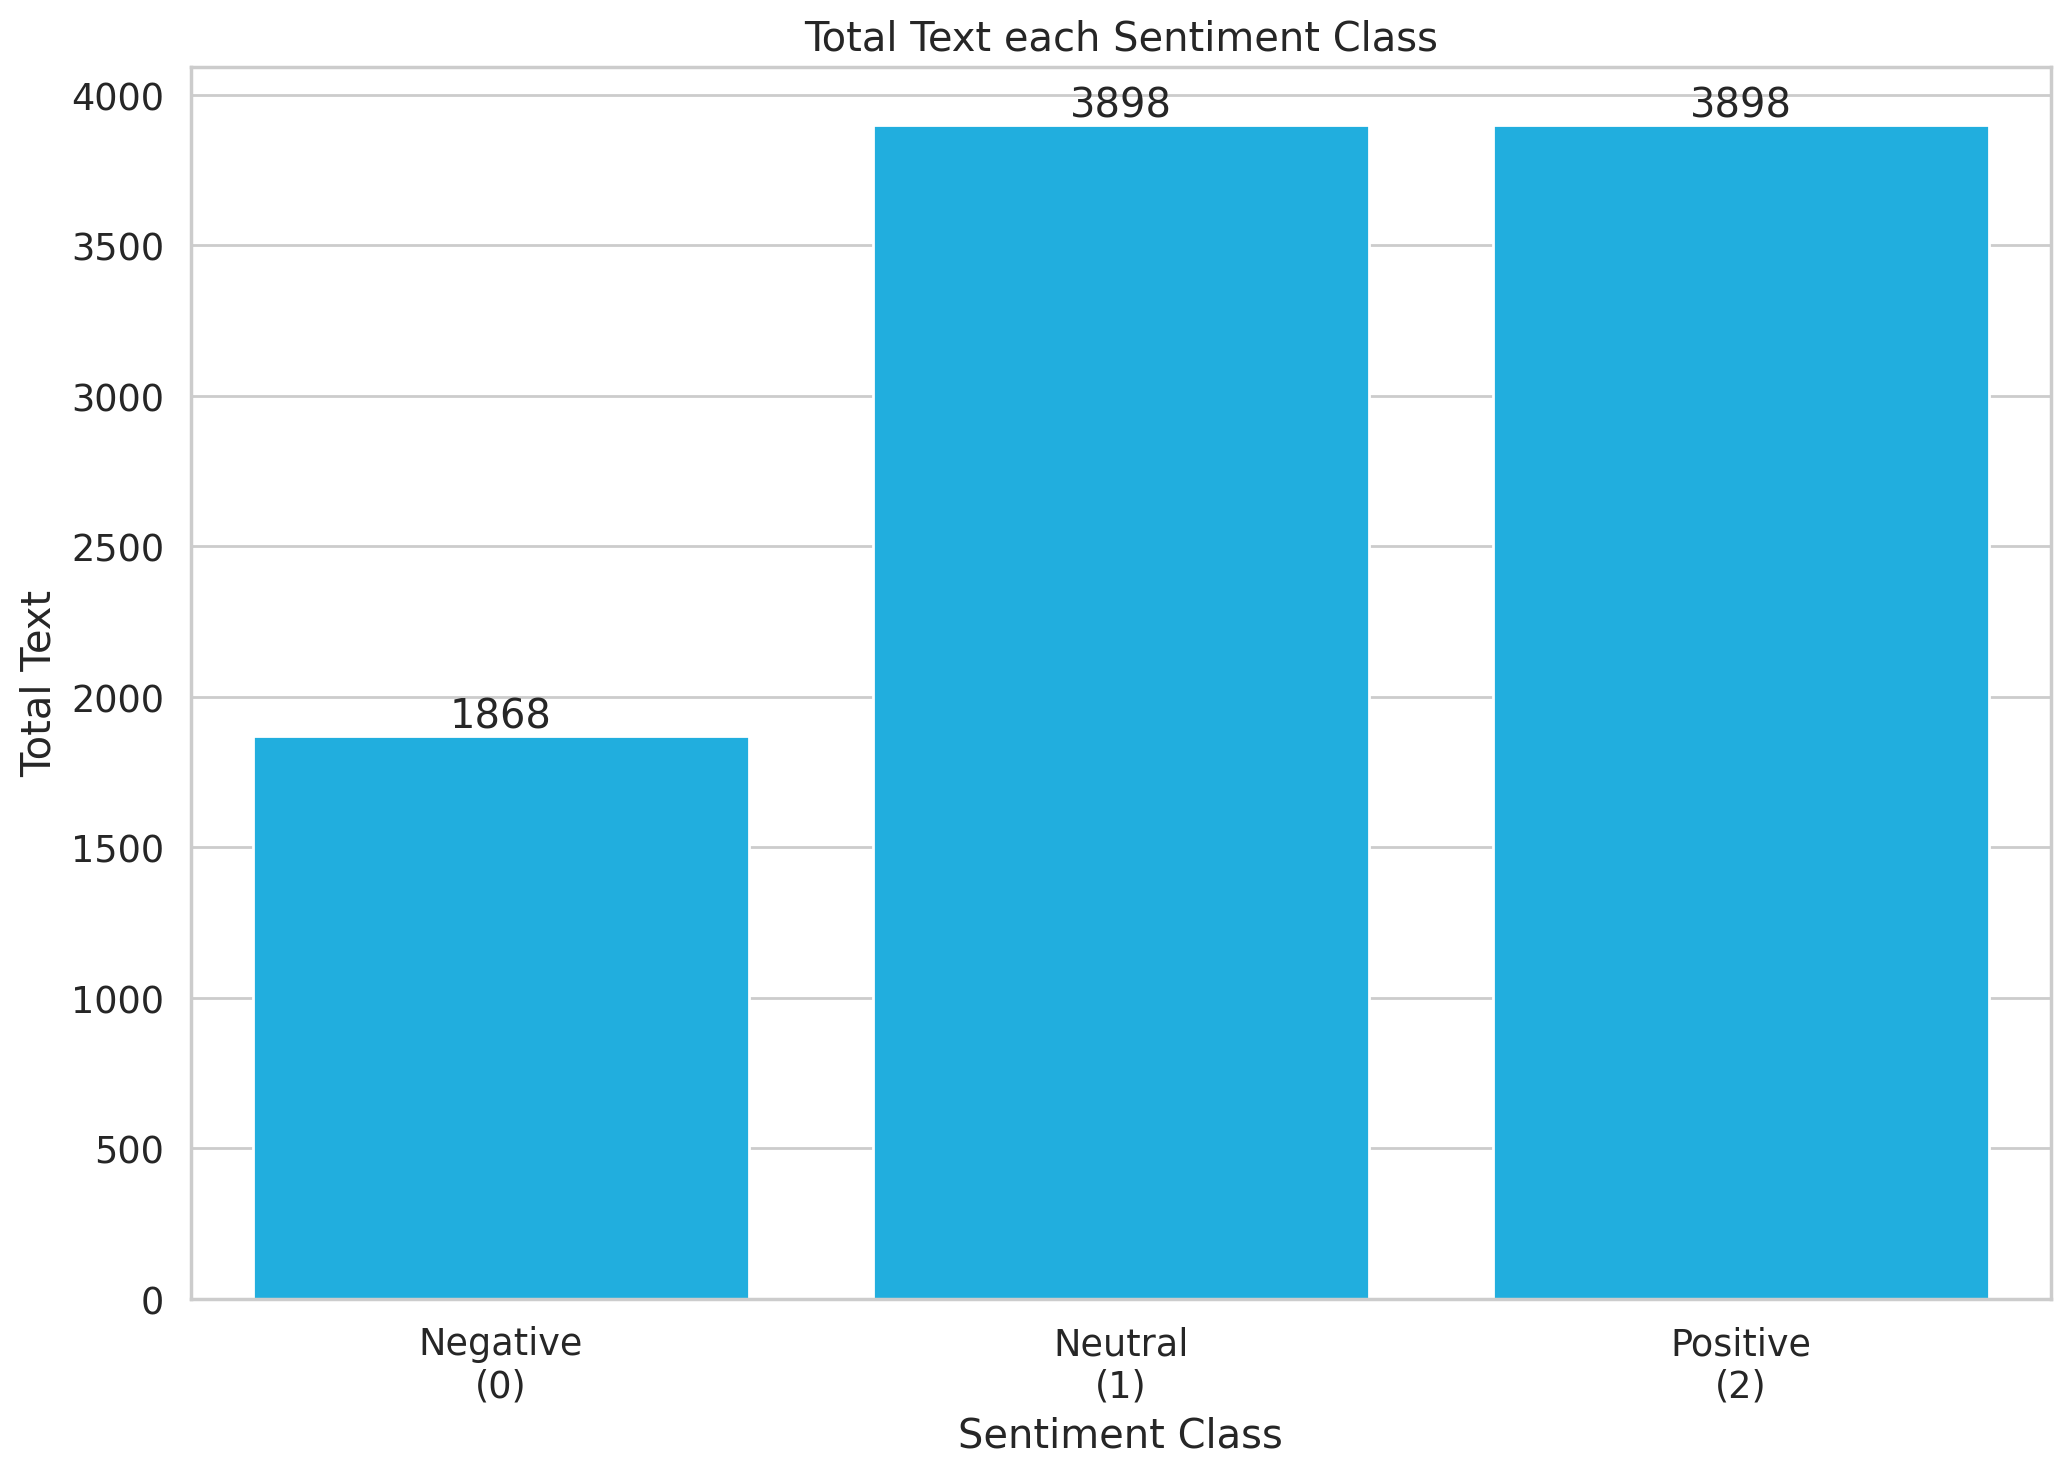

In [15]:
## Draw Graph Penyebaran Class Sentiment
ax = sns.barplot(data=df_class_sentimen, x='class', y='total');
ax.set(xlabel='Sentiment Class',
       ylabel='Total Text',
       title='Total Text each Sentiment Class')
ax.bar_label(container=ax.containers[0], labels=df_class_sentimen.total)

# Save Image
plt.savefig('report/'+hashtag+'/total_penyebaran_kelas_sentiment.png')

## **Model Training**

#### **Load Model dan Tokenizier**

In [16]:
## Declare Bert Model and Load Tokenizer + Bert Untrained.

from transformers import AutoTokenizer, AutoModel

# Ganti ini kalau mau ganti model basennya.
MODEL_NAME = 'indolem/indobert-base-uncased'

# Load Token sama Base Model.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

#### **Penyebaran Token Length pada Data**

In [17]:
df_data = df_data.astype({'text_final':'str'})
df_data.dtypes

id_tweet        int64
link           object
text           object
labelling       int64
text_final     object
labelled      float64
dtype: object

In [18]:
## Declare Variable Tampung
token_lens = []

## Count Length Token each Text Row.
for txt in df_data.text_final:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-19-d6322e56aeb7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


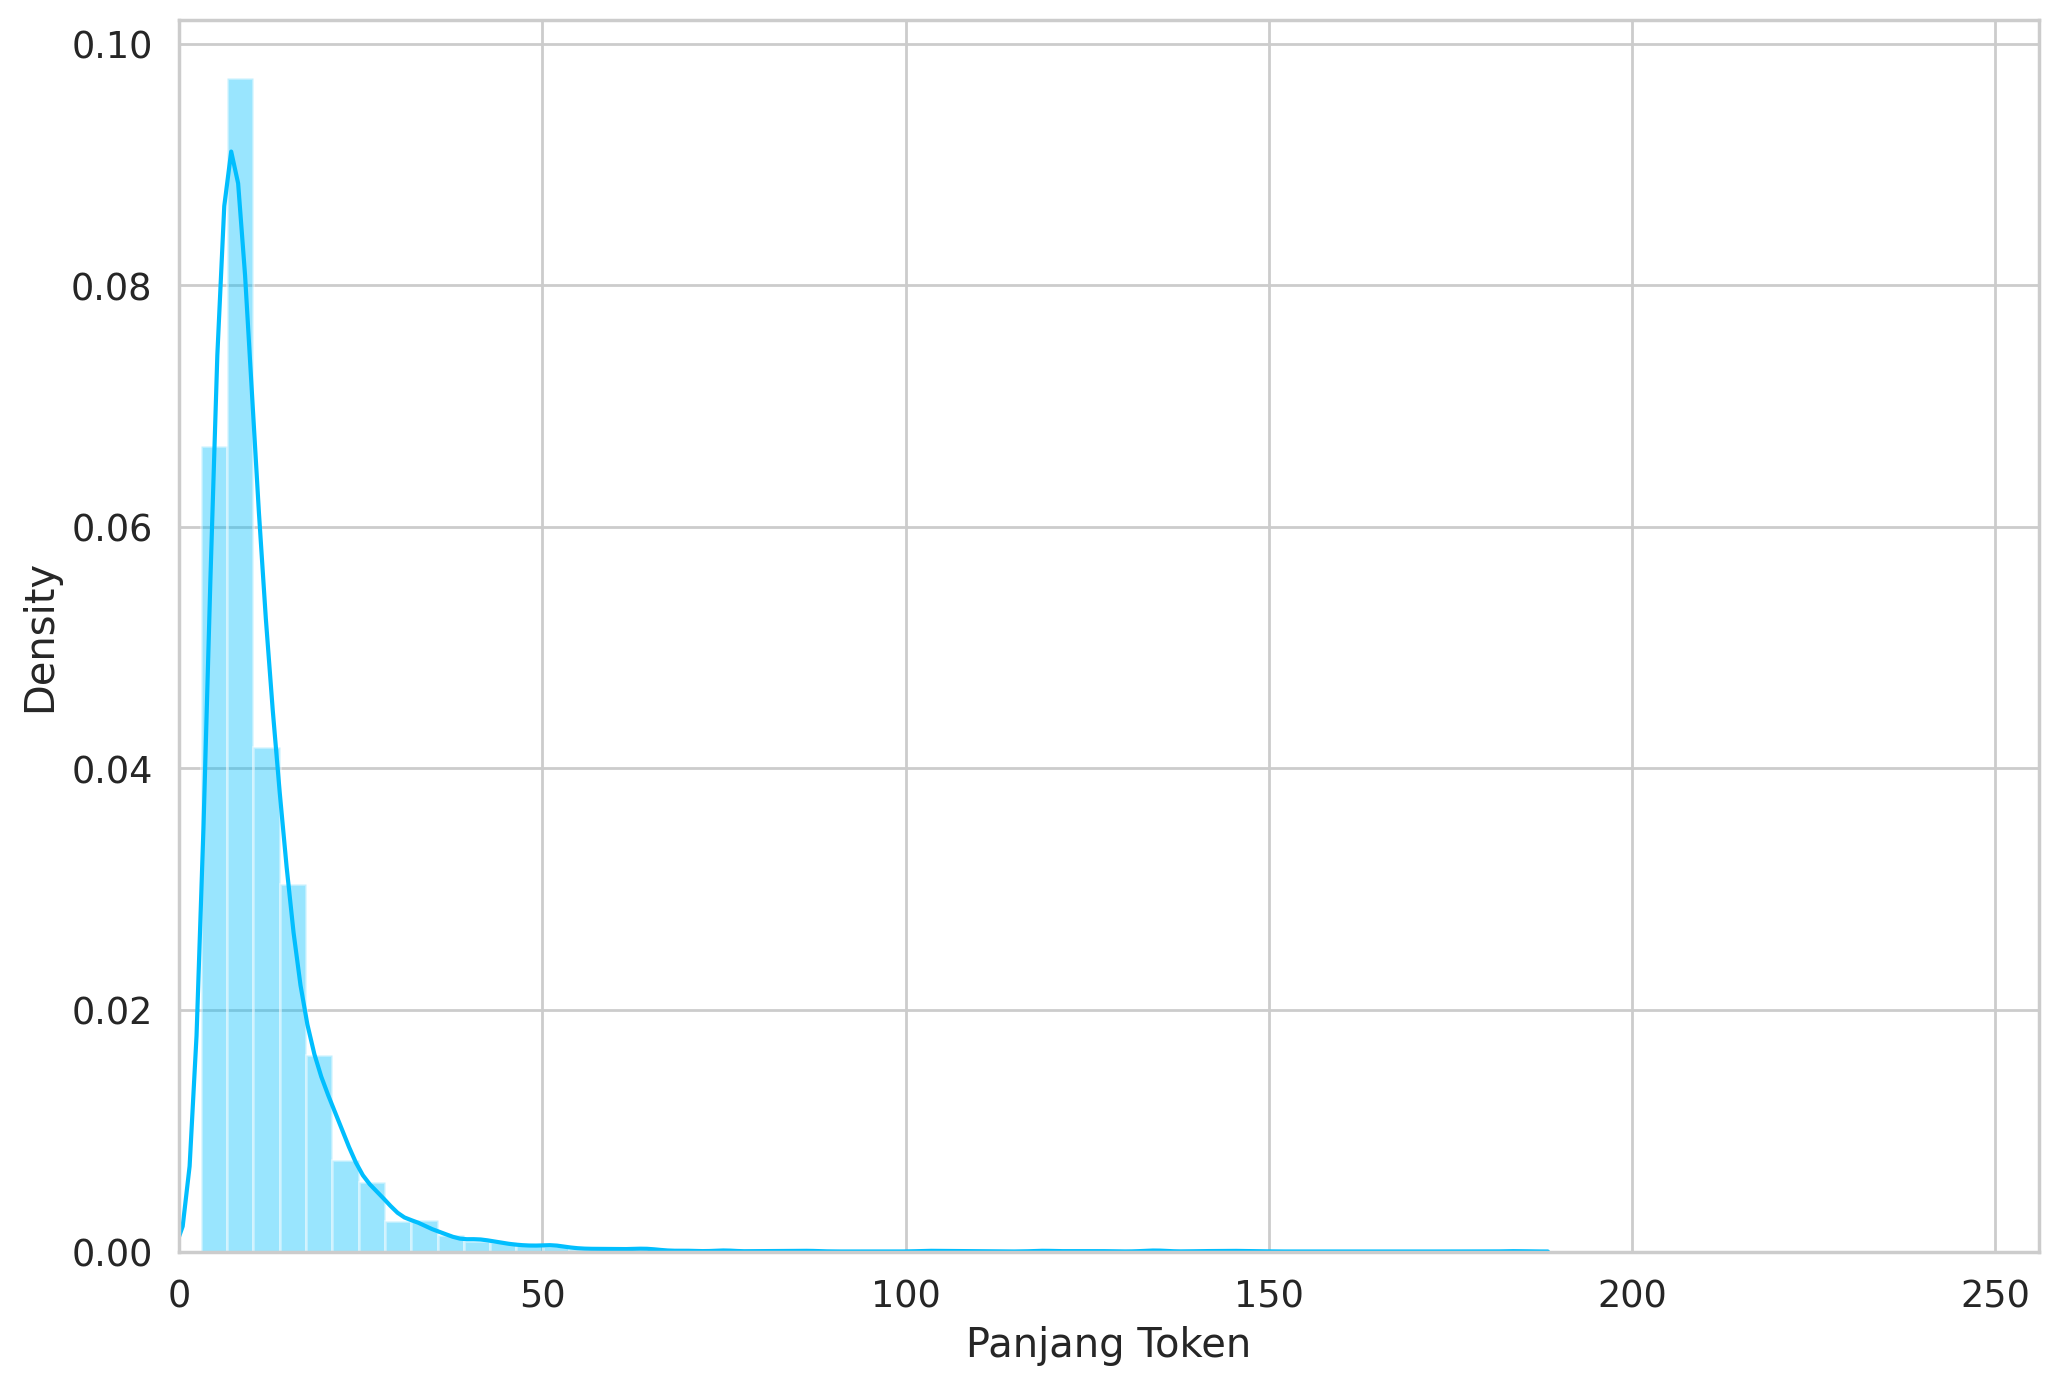

In [19]:
## Plotting Graph
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Panjang Token');

# Save Image
plt.savefig('report/'+hashtag+'/penyebaran_panjang_token.png')

In [20]:
## Set MAX_LEN token berdasarkan data diatas.
MAX_LEN = 200

## **Dataset Splitting 80% Training, 10% Testing, 10% Validation**


In [21]:
## Splitting Data to 20% Testing and 80% Train
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=RANDOM_SEED)

## Splitting Data from 20% Testing to 10% Testing and 10% Training
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

## Save Dataframe Each Part
df_train.to_csv('data/training/'+folder+'/'+folder+'_train.csv', index=False)
df_test.to_csv('data/training/'+folder+'/'+folder+'_test.csv', index=False)
df_val.to_csv('data/training/'+folder+'/'+folder+'_val.csv', index=False)

print(df_train.shape, df_val.shape, df_test.shape)

(7731, 6) (966, 6) (967, 6)


## **Data Loader**



In [22]:
## Declare Function for Encoding Tensor

class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len, id_tweet):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.id_tweet = id_tweet

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        ##
        id_tweet = str(self.id_tweet[item])
        ##
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'id_tweet': id_tweet
        }

In [23]:
## Define Function Data Loader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text_final.to_numpy(),
        targets=df.labelled.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        id_tweet=df.id_tweet.to_numpy()
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [24]:
## Create train, test, val data loader and Set BATCH SIZE
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
## Examples Data after masuk ke Data Loader
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
print(data['review_text'])
print(data['id_tweet'])

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'id_tweet'])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])
['ultra x itzy', 'handphone iphone berapa ', 'mau tapi kuningan jabar belum ada', 'jalan bogor tidak dulu wkwkwkw', 'photocard admin photocard sedih bismillah', 'ultramilk buat putus tegas tidak rugi pihak jujur fatal banget sih kasihan final lain vote murni', 'love ', 'memang top ultra milk', 'otw beli 100 dpet hanji', 'iklan tydack skip', 'ada minum tidak nyangkut leher mas ultramilk', 'tempat sudah beli 4 dpet 1 photocard tapi tidak tahu beli susu ultra besar kecil', 'bismillah beli dus dapat hyunjin', 'tanggal 14 maret kemarin sudah kirim kode unik dapat 1 botol sosro gratis tapi sayang syarat terlalu ribet harus pakai ktp npwp lain wajib padahal tukar cuma gratis 1 ultramilk 250ml bukan 1 kontainer', 'walaupun aku inteloran laktosa tetap bakal aku borong', '1 photocard 1 susu bela in beli kecil biasa beli 1l soal']
['1898', '2809', '7591', '

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##**Class Sentiment Classifier**

In [26]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [27]:
## Declare Class Sentiment
class_names = ['Negative', 'Neutral', 'Positive']

In [28]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [29]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


##**Training Function**

In [30]:
# Declare Epoch
EPOCHS = 5
LR = 0.00003

# Select Optimizer sama Declare nilai Learning Rate
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

##**Training**

In [33]:
# Check Path is Available if no Create Dir
if path.exists(root_file+'/model/'+hashtag) == False:
  os.makedirs(root_file+'/model/'+hashtag)
else :
  print("File Already Existed")

File Already Existed


In [34]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc.detach().cpu().numpy())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.detach().cpu().numpy())
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model/'+hashtag+'/bert_model_e'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.pkl')
        best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.0787054558923421 accuracy 0.426464881645324
Val loss 1.0647019001304125 accuracy 0.375776397515528

Epoch 2/5
----------
Train loss 1.0437332644196582 accuracy 0.4600957185357651
Val loss 0.9869496988468482 accuracy 0.5424430641821947

Epoch 3/5
----------
Train loss 0.925016353691905 accuracy 0.5890570430733411
Val loss 0.8616502529284993 accuracy 0.6200828157349897

Epoch 4/5
----------
Train loss 0.7909341695880102 accuracy 0.6793429051869098
Val loss 0.7813970001994587 accuracy 0.6987577639751553

Epoch 5/5
----------
Train loss 0.6889162753547026 accuracy 0.7367740266459707
Val loss 0.7365490376460747 accuracy 0.7225672877846792

CPU times: user 14min 38s, sys: 6min 30s, total: 21min 8s
Wall time: 21min 41s


##**Training History**


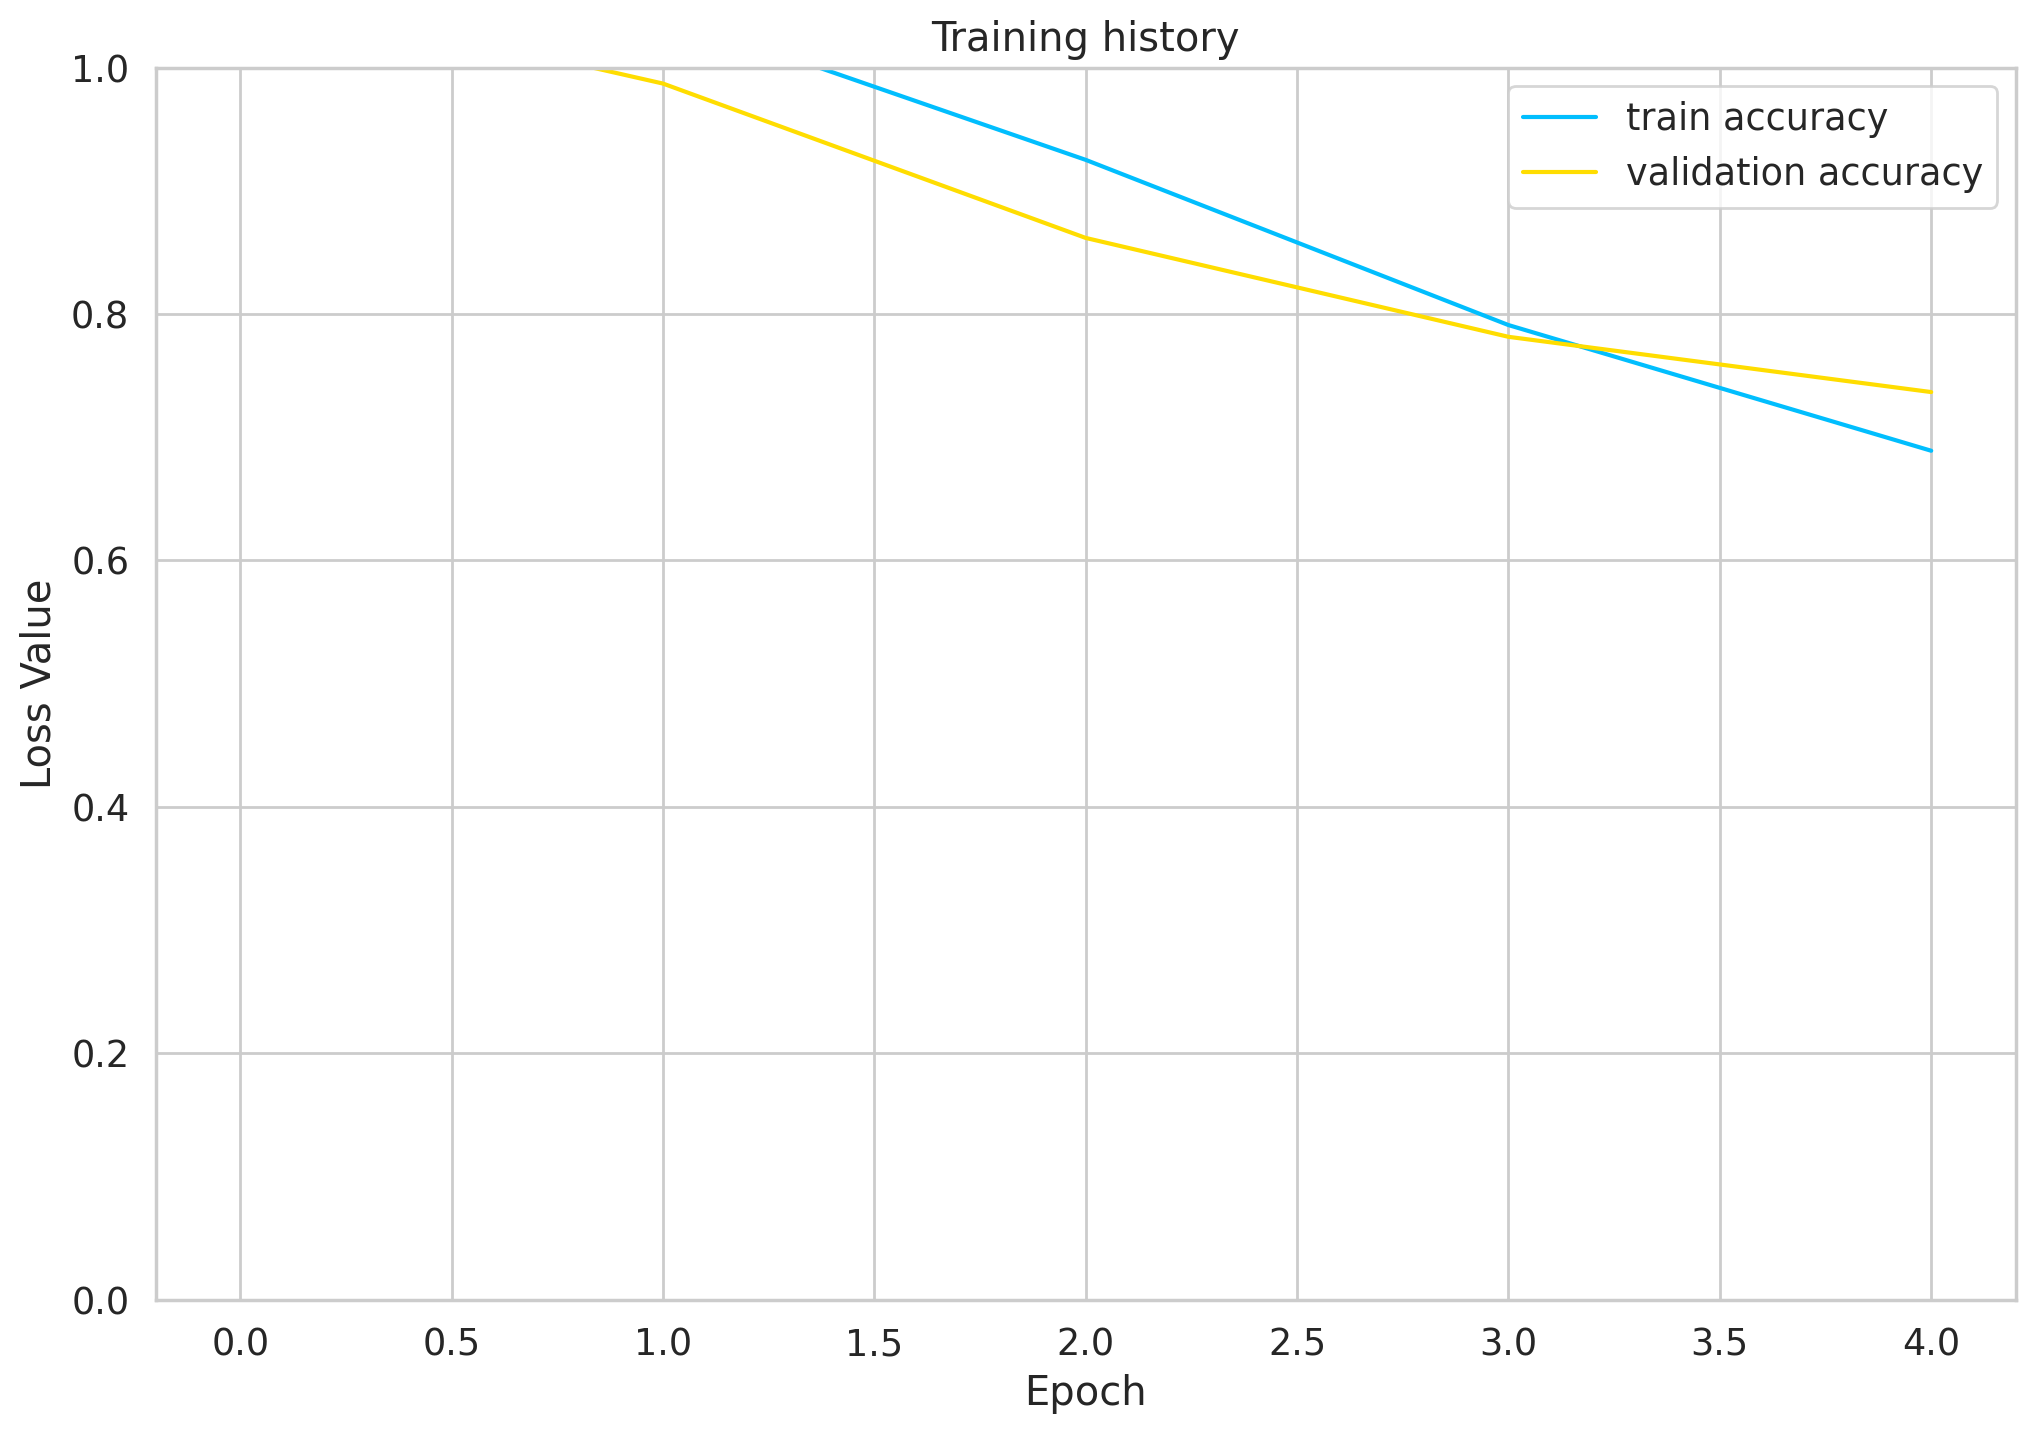

In [35]:
plt.plot(history['train_loss'], label='train accuracy')
plt.plot(history['val_loss'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Save Image Wordcloud Generated
plt.savefig('report/'+hashtag+'/training_history_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.png')

##**LOAD MODEL - Jika Diperlukan**


In [36]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('model/'+hashtag+'/bert_model_e'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.pkl'))
# model = model.to(device)

##**Model Evaluation - Classification Report, Report Data, Confussion Matrixs, Fungsi Prediksi**

#### **Get Accuracy dan Declare Fungsi Prediction**

In [37]:
## Print Testing Accuracy

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7114788004136505

In [38]:
## Declare Function Prediction

def get_predictions(model, data_loader):
    model = model.eval()

    ##
    id_text = []
    ##
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            ##
            id = d["id_tweet"]
            ##
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            ##
            id_text.extend(id)
            ##
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values, id_text

#### **Pengolahan Data untuk Recap Training Data**

In [39]:
## DATA UNTUK TRAINING RECAP
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_train_false = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_train_false.loc[len(df_train_false.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_testing']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_train_false['id_tweet']=df_train_false['id_tweet'].astype(int)

df_train_false

,id_tweet,predicted,status
0,5580,Neutral,data_testing
1,11228,Negative,data_testing
2,1612,Neutral,data_testing
3,5434,Neutral,data_testing
4,7472,Neutral,data_testing
...,...,...,...
962,7423,Neutral,data_testing
963,10142,Positive,data_testing
964,9756,Positive,data_testing
965,2559,Neutral,data_testing


In [40]:
## DATA UNTUK VALIDATION RECAP dan Export Data ALL
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    val_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_validation = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_validation.loc[len(df_validation.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_validation']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_validation['id_tweet']=df_validation['id_tweet'].astype(int)

df_merge = pd.concat([df_train_false, df_validation], axis=0)
df_merge.reset_index(drop='true')
df_joined = df_data_asli.join(df_merge.set_index('id_tweet'), on='id_tweet')
df_joined.reset_index(drop="true")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,id_tweet,date,platform,brand,hashtag,name,username,profile_id,comments,share_retweet,bookmark,quotes,likes,link,text,labelling,text_final,labelled,predicted,status
0,0,17-9-2022,TikTok - Komentar,ultramilk,dontstopyourmove,renata👊,rinn_lovers,https://www.tiktok.com/@rinn_lovers,0.0,NaN,NaN,NaN,0,https://www.tiktok.com/@uglyeoja/video/7143900...,Yuviii,1,yuvi,1.0,NaN,NaN
1,1,2022-07-09 00:00:00,Instagram,ultramilk,#DontStopYourMove,حنفة اليس فترىانى,_hanifals_,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CftPm-yho6M,@__inayatulll__ yuniiiii😍😂,1,yuni,1.0,NaN,NaN
2,2,2022-07-08 00:00:00,Instagram,ultramilk,#DontStopYourMove,Zia,zzizabae,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/Cfu2lbTh2y8,Yuna 😍,1,yuna,1.0,NaN,NaN
3,3,2020-01-01,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,0.0,0.0,0.0,0.0,0,Mentionlytics,"Halo teman - teman, saya mau sharing nih, peng...",2,halo teman teman mau sharing alam juang kumpul...,2.0,NaN,NaN
4,4,2020-01-01,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,0.0,0.0,0.0,0.0,0,Mentionlytics,sebulan penuh bersama ultramilk jaya jaya jaya...,1,bulan penuh sama ultramilk jaya jaya jaya tert...,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14032,14032,2023-11-30 00:00:00,Instagram,ultramilk,#iamULTRAoddinary,chik mia,mia.chik,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CzFsyLArKoe,kesyukaanku,2,kesyukaanku,2.0,NaN,NaN
14033,14033,2022-05-05 00:00:00,Instagram,Manipulation,Manipulation,Jaguar,jaguarfarizal,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CbBnsdpJ1MV,@m_husen90 Sekelas ultramilk ngadain ultramilk...,0,kelas ultramilk ada harus isi data2 ktp npwp c...,0.0,NaN,NaN
14034,14034,2023-11-29,Twitter,ultramilk,iamultraoddinary,COPPAMAGZ,@coppamagz,769863624982601728,0.0,2.0,0.0,1.0,9,https://twitter.com/coppamagz/status/172972752...,Hayoo mana nih yang kemarin pas event #iamULTR...,4,hayoo mana kemarin pas event iamultraoddinary ...,NaN,NaN,NaN
14035,14035,2022-05-05 00:00:00,Instagram,Manipulation,Manipulation,Jaguar,jaguarfarizal,Nan,NaN,NaN,NaN,NaN,2,https://www.instagram.com/p/CbBnsdpJ1MV,Jangan ada yang ikutan deh sama program receh...,0,jangan ada ikut sama program tidak tarik dari ...,0.0,NaN,NaN


In [41]:
## Adding Data if polarity 4 and used for training
df_joined.loc[df_joined.labelling == 4, 'predicted'] = 'Not Predicted'
df_joined.loc[df_joined.labelling == 4, 'status'] = 'other'
df_joined.loc[df_joined.labelling == 4, 'labelled'] = 'Not Labelled'

df_joined.loc[df_joined.predicted.isnull() == True, 'predicted'] = 'Data Training'
df_joined.loc[df_joined.status.isnull() == True, 'status'] = 'data_training'
df_joined

,id_tweet,date,platform,brand,hashtag,name,username,profile_id,comments,share_retweet,bookmark,quotes,likes,link,text,labelling,text_final,labelled,predicted,status
0,0,17-9-2022,TikTok - Komentar,ultramilk,dontstopyourmove,renata👊,rinn_lovers,https://www.tiktok.com/@rinn_lovers,0.0,NaN,NaN,NaN,0,https://www.tiktok.com/@uglyeoja/video/7143900...,Yuviii,1,yuvi,1.0,Data Training,data_training
1,1,2022-07-09 00:00:00,Instagram,ultramilk,#DontStopYourMove,حنفة اليس فترىانى,_hanifals_,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CftPm-yho6M,@__inayatulll__ yuniiiii😍😂,1,yuni,1.0,Data Training,data_training
2,2,2022-07-08 00:00:00,Instagram,ultramilk,#DontStopYourMove,Zia,zzizabae,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/Cfu2lbTh2y8,Yuna 😍,1,yuna,1.0,Data Training,data_training
3,3,2020-01-01,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,0.0,0.0,0.0,0.0,0,Mentionlytics,"Halo teman - teman, saya mau sharing nih, peng...",2,halo teman teman mau sharing alam juang kumpul...,2.0,Data Training,data_training
4,4,2020-01-01,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,Mentionlytics,0.0,0.0,0.0,0.0,0,Mentionlytics,sebulan penuh bersama ultramilk jaya jaya jaya...,1,bulan penuh sama ultramilk jaya jaya jaya tert...,1.0,Data Training,data_training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14032,14032,2023-11-30 00:00:00,Instagram,ultramilk,#iamULTRAoddinary,chik mia,mia.chik,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CzFsyLArKoe,kesyukaanku,2,kesyukaanku,2.0,Data Training,data_training
14033,14033,2022-05-05 00:00:00,Instagram,Manipulation,Manipulation,Jaguar,jaguarfarizal,Nan,NaN,NaN,NaN,NaN,0,https://www.instagram.com/p/CbBnsdpJ1MV,@m_husen90 Sekelas ultramilk ngadain ultramilk...,0,kelas ultramilk ada harus isi data2 ktp npwp c...,0.0,Data Training,data_training
14034,14034,2023-11-29,Twitter,ultramilk,iamultraoddinary,COPPAMAGZ,@coppamagz,769863624982601728,0.0,2.0,0.0,1.0,9,https://twitter.com/coppamagz/status/172972752...,Hayoo mana nih yang kemarin pas event #iamULTR...,4,hayoo mana kemarin pas event iamultraoddinary ...,Not Labelled,Not Predicted,other
14035,14035,2022-05-05 00:00:00,Instagram,Manipulation,Manipulation,Jaguar,jaguarfarizal,Nan,NaN,NaN,NaN,NaN,2,https://www.instagram.com/p/CbBnsdpJ1MV,Jangan ada yang ikutan deh sama program receh...,0,jangan ada ikut sama program tidak tarik dari ...,0.0,Data Training,data_training


In [42]:
## Export Data Training, Testing, and Validation Result
df_joined.to_excel("report/"+hashtag+"/data_report_training.xlsx")

#### **Classification Report**

In [43]:
## Do Testing Classification Report
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
## Output Classification Report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.62      0.45      0.52       186
     Neutral       0.70      0.77      0.73       395
    Positive       0.75      0.78      0.77       386

    accuracy                           0.71       967
   macro avg       0.69      0.67      0.67       967
weighted avg       0.71      0.71      0.71       967



In [45]:
## Save Classification Report
# Save Data Classification Report
class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
# Export Classification Report
df_cf = pd.DataFrame(class_report).transpose()
df_cf.to_csv('report/'+hashtag+'/classification_report_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.csv', index=False)

#### **Confussion Matrix**

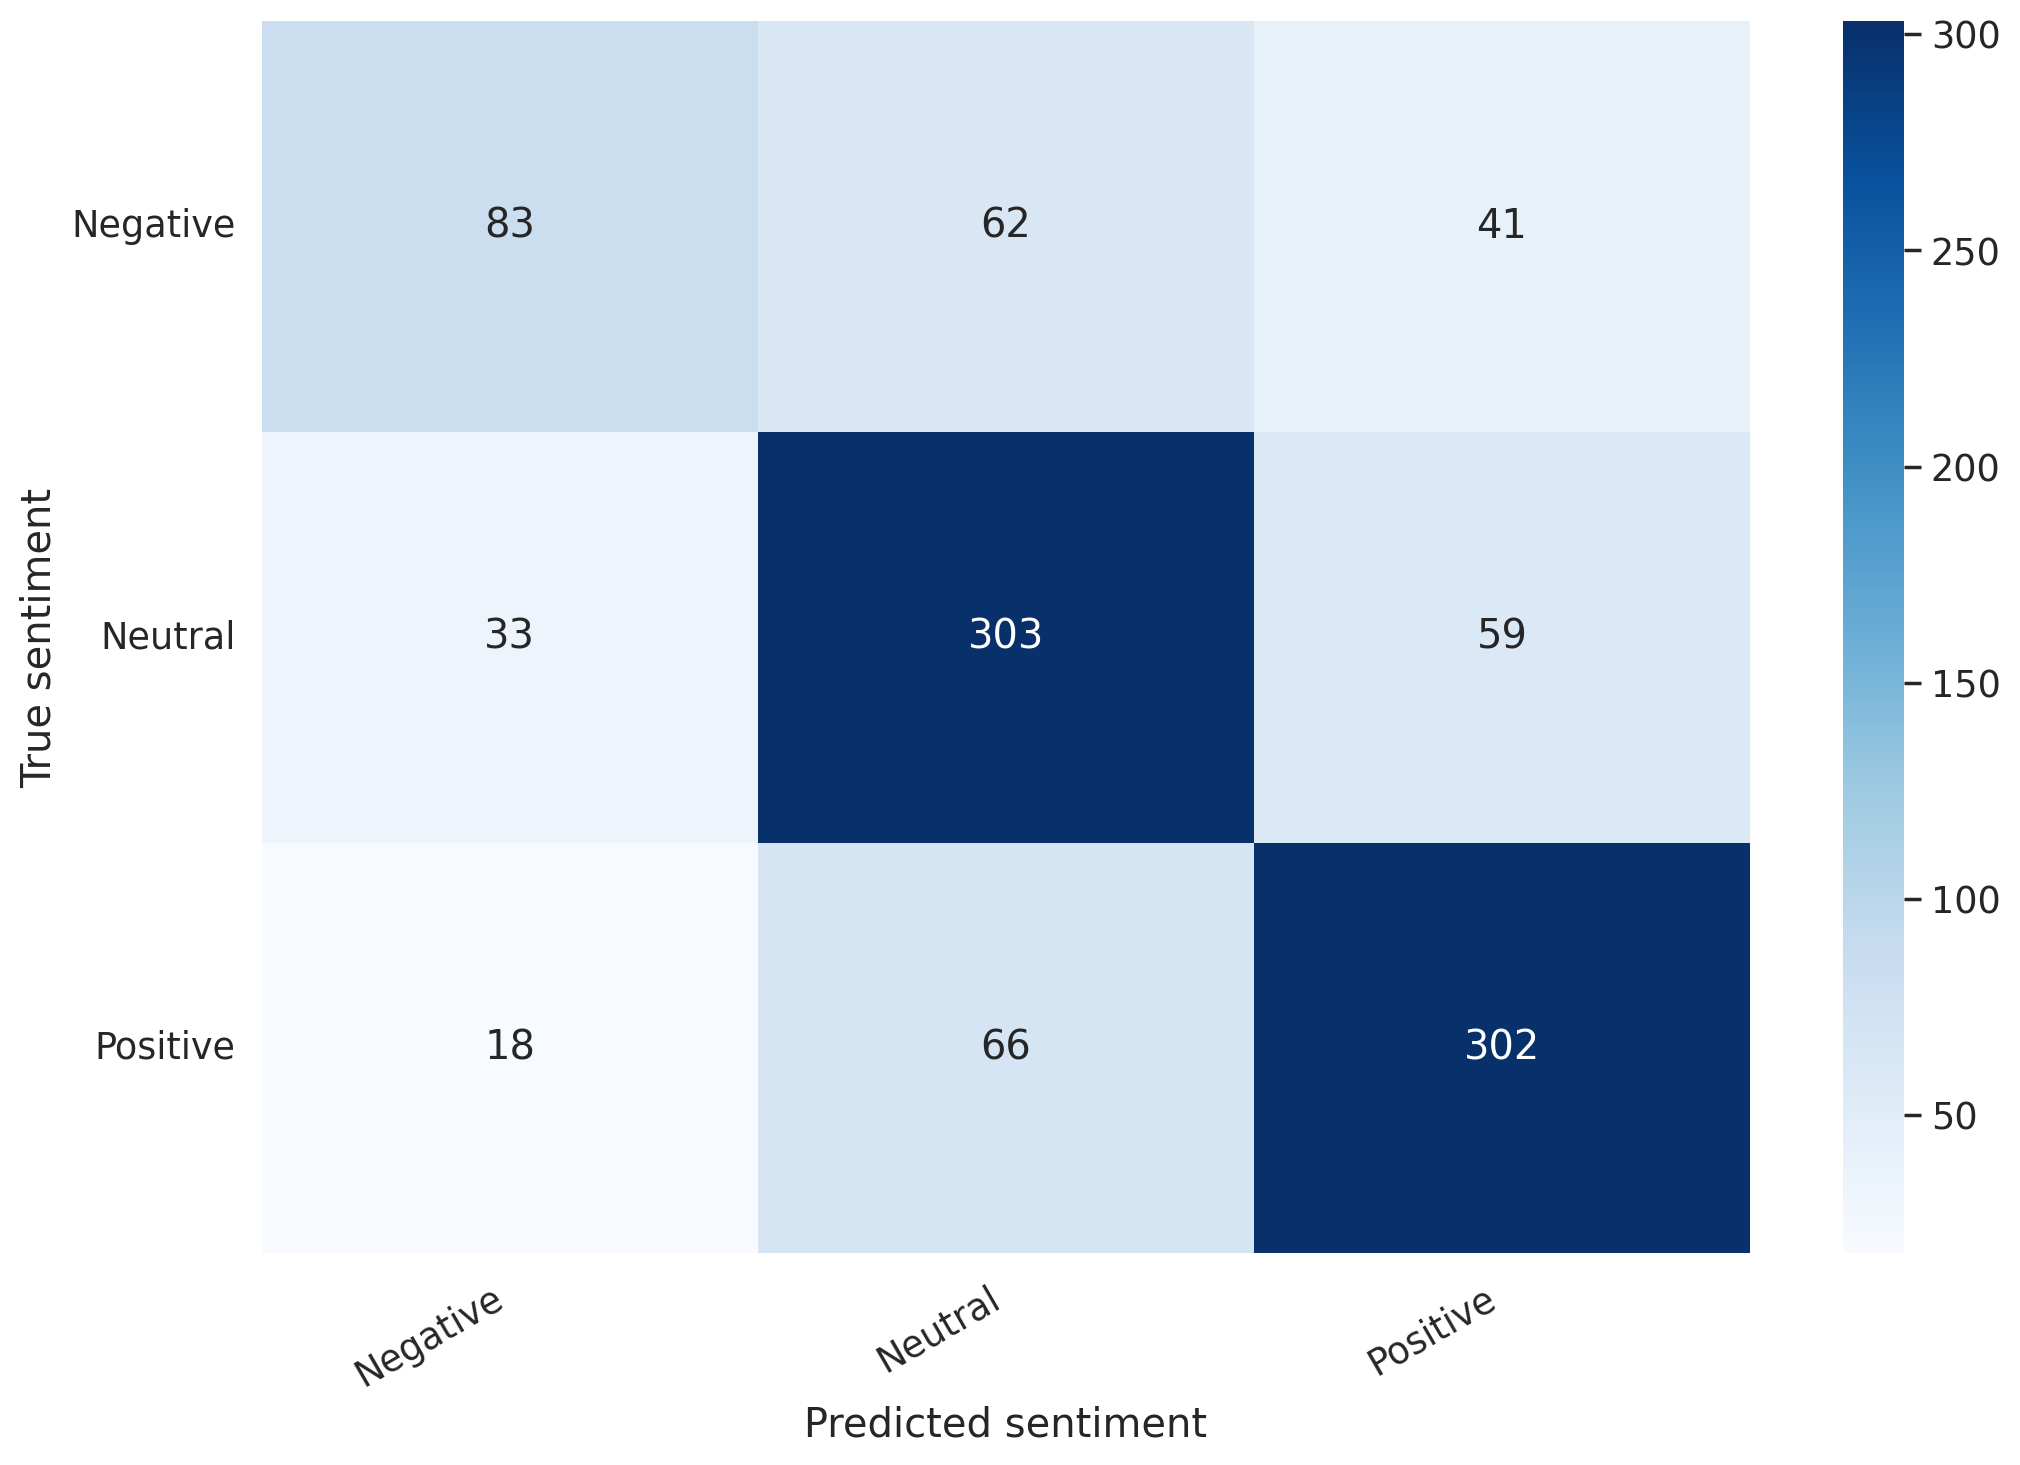

In [46]:
## Declare Function CF
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

## Do CF
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Save Image
plt.savefig('report/'+hashtag+'/confusion_matrix_'+str(EPOCHS)+'_lr'+str(LR)+'_bs'+str(BATCH_SIZE)+'.png')

In [47]:
df_cm

,Negative,Neutral,Positive
Negative,83,62,41
Neutral,33,303,59
Positive,18,66,302


##**Test Predict**

In [48]:
## Load Preprocess SLANG Module

# Load Dataframe
df_tmp_nasalsabila = pd.read_csv('data/slang/colloquial-indonesian-lexicon_nasalsabila.csv')
df_slang_fendiirfan = pd.read_csv('data/slang/colloquial-indonesian-lexicon_fendiirfan.csv')
df_slang_custom = pd.read_csv('data/slang/custom_dictonary_slang.csv')
df_slang_custom_exception = pd.read_csv('data/slang/custom_dictonary_slang_dont_swap.csv')

# Transform and Delete Duplicate Data from nasalsabila
df_slang_nasalsabila = df_tmp_nasalsabila[['slang', 'formal']]
df_slang_nasalsabila.drop_duplicates(inplace=True)

# Transform and Delete Duplicate Data from fendiirfan
df_slang_fendiirfan.dropna(inplace=True)
df_slang_fendiirfan.rename(columns={'kataAlay': 'slang', 'kataBaik': 'formal'}, inplace=True)
df_slang_fendiirfan.drop_duplicates(inplace=True)

# Transform and Delete Duplicate our own data.
df_slang_custom.drop_duplicates(inplace=True)
df_slang_custom_exception.drop_duplicates(inplace=True)

def remove_slang(text, df_tmp):
    # To Lowercase
    text = text.lower()

    # Pecah to array
    words = text.split(" ");

    # DF to Array
    arr_slang = df_tmp['slang'].to_numpy()
    arr_formal = df_tmp['formal'].to_numpy()
    do_not_change = df_slang_custom_exception['kata'].to_numpy()

    # Array New Text
    new_text = []

    for kata in words:
      if kata in arr_slang:
        if kata not in do_not_change:
          idx = np.where(arr_slang==kata)[0][0]
          kata = arr_formal[idx]

      new_text.append(kata)
      text_new = ' '.join(new_text)

    return text_new

<ipython-input-48-188833ac7026>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slang_nasalsabila.drop_duplicates(inplace=True)


In [49]:
## Load Preprocess Stemming Modul
# Load and Download Library Sastrawi
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Indonesian Stopword by Sastrawi
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.1 MB/s eta 0:00:00


In [50]:
## Load Preprocess Stopword Data

# Load Data Stopword from Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# Load Data Stopword and Custom Word
stopword_satya = list(pd.read_csv('data/stopword/stopwords_satya.txt', header = None)[0])
custom_stopword = list(pd.read_csv('data/stopword/custom_stopword.txt', header = None)[0])
keep_custom_stopword = list(pd.read_csv('data/stopword/keep_custom_stopword.txt', header = None)[0])

def remove_stopwords(text):
  # Removal Stopword
  text_split = text.split(' ')

  temp_text_split = []
  for i in range(len(text_split)):
    ## Remove Stopword by Satwa : gak dipake dulu ini terlalu ngilangin konteks text
    #if (text_split[i] not in stopword_satya) and (text_split[i] not in custom_stopword):
    if (text_split[i] not in custom_stopword):
      ## Keep Beberapa Kata Valence of a text
      # https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word#:~:text=Stop%20words%20are%20usually%20thought,idf%20analysis%20for%20document%20classification).
      if (text_split[i] in keep_custom_stopword) :
        temp_text_split.append(text_split[i])
      else :
        ## Stopword Removal from data by Sastrawi
        tmp = stopword.remove(text_split[i])
        temp_text_split.append(tmp)

  final_text = ' '.join(temp_text_split)

  # will replace single word
  final_text = re.sub(r"\b[a-zA-Z]\b","",final_text)

  # will replace space more than one
  final_text = re.sub("( {2,})"," ",final_text)

  return final_text

In [51]:
def clean_text_predict(text) :

    ## TEXT TRANSFORM
    # Remove hashtag dan @
    ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    # Change "-" to space
    text = text.replace("-", " ")
    # Remove punctiation
    text  = "".join([char for char in text if char not in string.punctuation])
    # Remove angka
    text = re.sub('[0-9]+', '', text)
    # Remove website link
    text = re.sub(r'http\S+', '', text)
    # Remove new line
    text = re.sub("\n"," ",text)
    # Transform to lowercase
    text = text.lower()
    # Replace perulangan huruf pada kalimat "iyaaa" to "iya"
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    # will replace space more than one
    text = re.sub('( {2,})',' ',text)

    ## SLANG
    text = remove_slang(text ,df_slang_nasalsabila)
    text = remove_slang(text ,df_slang_fendiirfan)
    text = remove_slang(text ,df_slang_custom)

    ## STEMMING
    text = stemmer.stem(text)

    ## STOPWORD
    text = remove_stopwords(text)

    ## TEXT TRANSFORM BUT AFTER
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)

    return text

In [52]:
review_text = "kemarin beli malah basi susunya"
txt_clean = clean_text_predict(review_text)

encoded_review = tokenizer.encode_plus(
    txt_clean,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text\t: {review_text}')
print(f'Clean text\t: {txt_clean}')
print(f'Sentiment\t: {class_names[prediction]}')

Review text	: kemarin beli malah basi susunya
Clean text	: kemarin beli malah basi susu
Sentiment	: Negative


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
